## READ ME

Name: Kim, Minjun

Student ID: 20195024

Instructions: Please run the cells one by one. This is because some variables used in the previous cell are also used in the later cell.  
This `HW4 Code.ipynb` contains codes of Q5~Q8. For the code of Q9, mini-competition of kaggle, I saved it separately as a file named `HW4 Code_mini_kaggle.ipynb`.

***
***
### **Q5**

In [73]:
import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize, poly)
from statsmodels.stats.anova import anova_lm
import seaborn as sns
import matplotlib.pyplot as plt

from pygam import (s as s_gam,l as l_gam,f as f_gam, LinearGAM,LogisticGAM)
from ISLP.transforms import (BSpline,NaturalSpline)
from ISLP.models import bs, ns
from ISLP.pygam import (approx_lam, degrees_of_freedom, plot as plot_gam,anova as anova_gam)
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

***
#### Q5(a) 

In [69]:
Wage = load_data('Wage')
y = Wage['wage']
age = Wage['age']

In [70]:
Wage.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [71]:
Wage.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        3000 non-null   int64   
 1   age         3000 non-null   int64   
 2   maritl      3000 non-null   object  
 3   race        3000 non-null   object  
 4   education   3000 non-null   category
 5   region      3000 non-null   object  
 6   jobclass    3000 non-null   object  
 7   health      3000 non-null   object  
 8   health_ins  3000 non-null   object  
 9   logwage     3000 non-null   float64 
 10  wage        3000 non-null   float64 
dtypes: category(1), float64(2), int64(2), object(6)
memory usage: 237.6+ KB


In [72]:
#1. ANOVA

poly_M_list=[]

for d in range(1,10):
    poly_age = MS([poly('age', degree=d)]).fit(Wage)
    M = sm.OLS(y, poly_age.transform(Wage)).fit()
    poly_M_list.append(M)

anova_list=anova_lm(* poly_M_list)

print(anova_list)

   df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0    2998.0  5.022216e+06      0.0            NaN         NaN           NaN
1    2997.0  4.793430e+06      1.0  228786.010128  143.811827  2.128079e-32
2    2996.0  4.777674e+06      1.0   15755.693664    9.903818  1.665559e-03
3    2995.0  4.771604e+06      1.0    6070.152124    3.815616  5.086990e-02
4    2994.0  4.770322e+06      1.0    1282.563017    0.806202  3.693177e-01
5    2993.0  4.766389e+06      1.0    3932.257665    2.471765  1.160134e-01
6    2992.0  4.763834e+06      1.0    2555.281281    1.606216  2.051232e-01
7    2991.0  4.763707e+06      1.0     126.668985    0.079622  7.778293e-01
8    2990.0  4.756703e+06      1.0    7004.317139    4.402820  3.596326e-02


Pr(>F) is the p-value for the F-statistic, so a low value (typically below 0.05) indicates  
that the new model is statistically significantly better than the previous model.


Moving from a linear to a quadratic model significantly improves fit (very low Pr(>F)=2.128079e-32).  
The cubic model is slightly better than the quadratic (Pr(>F) = 1.665559e-03),  
but higher degrees(where $d>=4$) do not provide statistically significant improvements,  
with the 4th degree and above not considered significant.  

Therefore, using ANOVA, the optimal degree is 3, the cubic model.

Degree 1: Cross-validation MSE = 1675.0142
Degree 2: Cross-validation MSE = 1599.5982
Degree 3: Cross-validation MSE = 1594.7262
Degree 4: Cross-validation MSE = 1593.9141
Degree 5: Cross-validation MSE = 1595.4331
Degree 6: Cross-validation MSE = 1594.9302
Degree 7: Cross-validation MSE = 1598.9376
Degree 8: Cross-validation MSE = 1599.4999
Degree 9: Cross-validation MSE = 1599.4215

Optimal polynomial degree: 4


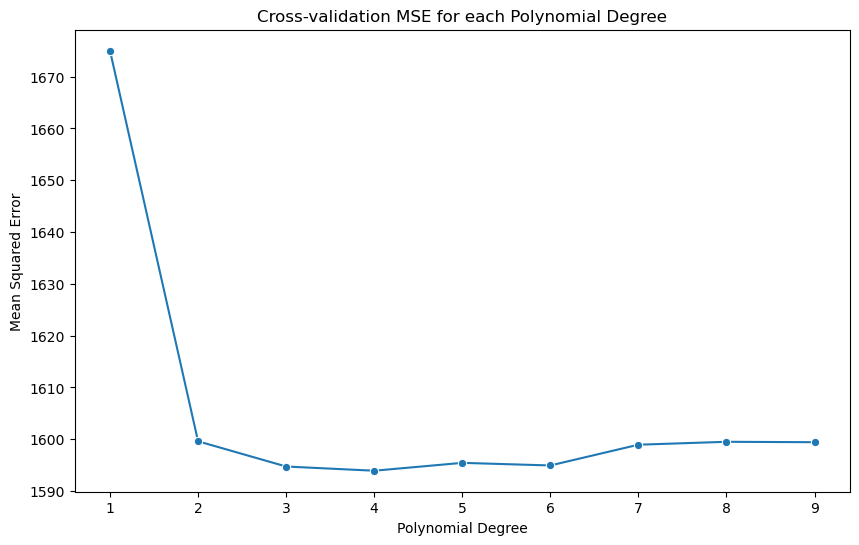

In [75]:
#2. Cross-validation
degrees = list(range(1, 10))
mse_scores = []

for degree in degrees:
    poly_features = PolynomialFeatures(degree=degree)
    X_poly = poly_features.fit_transform(age.values.reshape(-1, 1))
    model = LinearRegression()
    
    #Compute MSE after cross-validation
    score = -np.mean(cross_val_score(model, X_poly, y, scoring='neg_mean_squared_error', cv=5))
    mse_scores.append(score)    
    
    print(f"Degree {degree}: Cross-validation MSE = {score:.4f}") #Print the cross-validation scores for degree 1~9

#Finding the optimal degree
optimal_index = np.argmin(mse_scores)
best_degree = degrees[optimal_index]
print(f"\nOptimal polynomial degree: {best_degree}")


scores_df = pd.DataFrame({'Degree': degrees, 'MSE': mse_scores})
plt.figure(figsize=(10, 6))
sns.lineplot(x='Degree', y='MSE', data=scores_df, marker='o')
plt.title('Cross-validation MSE for each Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.xticks(degrees)
plt.show()

Therefore, using cross-validation, the optimal polynomial degree is 4.  
This is different from the previous outcome of ANOVA.

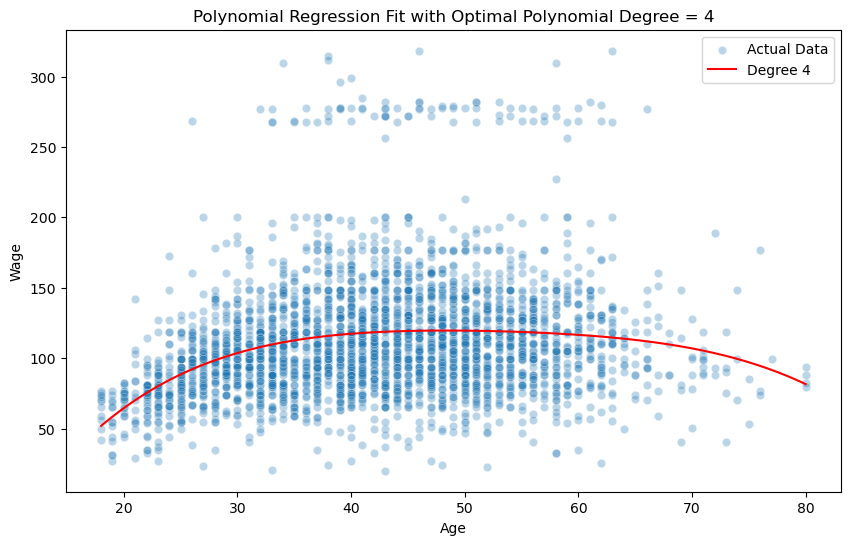

In [76]:
#Using the optimal degree=4
poly_features = PolynomialFeatures(degree=best_degree)
X_poly = poly_features.fit_transform(age.values.reshape(-1, 1))
best_poly_model = LinearRegression()
best_poly_model.fit(X_poly, y)

#Generate a range of features for prediction
age_range = np.linspace(age.min(), age.max(), 200).reshape(-1, 1)
age_range_poly = poly_features.transform(age_range)
predictions = best_poly_model.predict(age_range_poly)

#Plot polynomial regression
plt.figure(figsize=(10, 6))
sns.scatterplot(x=age, y=y, alpha=0.3, label='Actual Data')
sns.lineplot(x=age_range.flatten(), y=predictions, color='red', label=f'Degree {best_degree}')
plt.xlabel('Age')
plt.ylabel('Wage')
plt.title('Polynomial Regression Fit with Optimal Polynomial Degree = 4')
plt.legend()
plt.show()

***
#### Q5(b)

Cuts 2: Cross-validation MSE = 1702.7384
Cuts 3: Cross-validation MSE = 1658.8779
Cuts 4: Cross-validation MSE = 1640.5522
Cuts 5: Cross-validation MSE = 1637.0180
Cuts 6: Cross-validation MSE = 1629.9668
Cuts 7: Cross-validation MSE = 1623.8845
Cuts 8: Cross-validation MSE = 1618.9513
Cuts 9: Cross-validation MSE = 1619.7970
Cuts 10: Cross-validation MSE = 1616.5657
Cuts 11: Cross-validation MSE = 1620.3665
Cuts 12: Cross-validation MSE = 1616.9932
Cuts 13: Cross-validation MSE = 1613.9291
Cuts 14: Cross-validation MSE = 1608.1644
Cuts 15: Cross-validation MSE = 1611.7606
Cuts 16: Cross-validation MSE = 1611.3098
Cuts 17: Cross-validation MSE = 1609.6753
Cuts 18: Cross-validation MSE = 1612.5451
Cuts 19: Cross-validation MSE = 1617.0253
Cuts 20: Cross-validation MSE = 1612.8496

Optimal number of cuts: 14


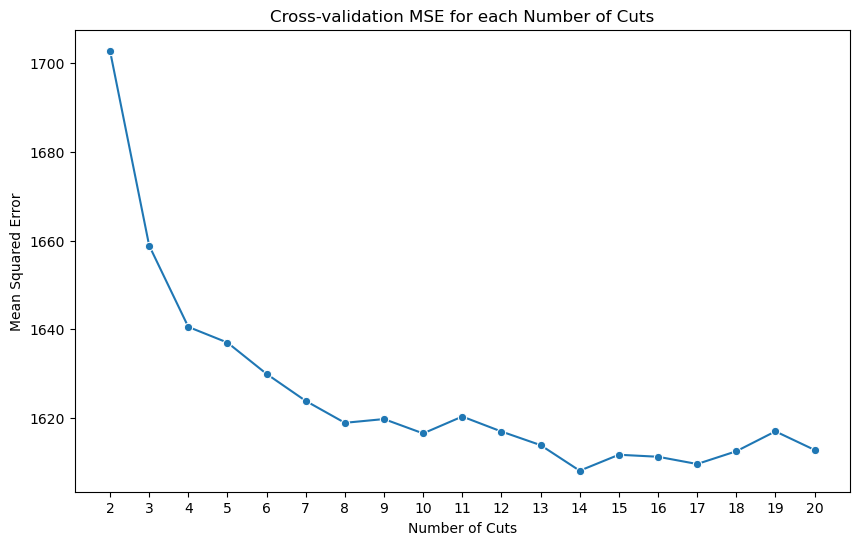

In [77]:
cuts_list = list(range(2, 21))
mse_scores = []
for cuts in cuts_list:
    cut_age = pd.qcut(age, q=cuts)
    X_cut = pd.get_dummies(cut_age)
    model = LinearRegression()
    
    #Compute MSE after cross-validation
    score = -np.mean(cross_val_score(model, X_cut, y, scoring='neg_mean_squared_error', cv=5))
    mse_scores.append(score)

    #Print the cross-validation scores for cuts 2~20
    print(f"Cuts {cuts}: Cross-validation MSE = {score:.4f}")

optimal_index = np.argmin(mse_scores)
best_cuts = cuts_list[optimal_index]
print(f"\nOptimal number of cuts: {best_cuts}")

#Plot the cross-validation mse
cuts_df = pd.DataFrame({'Cuts': cuts_list, 'MSE': mse_scores})
plt.figure(figsize=(10, 6))
sns.lineplot(x='Cuts', y='MSE', data=cuts_df, marker='o')
plt.title('Cross-validation MSE for each Number of Cuts')
plt.xlabel('Number of Cuts')
plt.ylabel('Mean Squared Error')
plt.xticks(cuts_list)
plt.show()


I can increase the number of cuts until I reach the unique number of values in the age variable,  
but this equates to having only one data point for each interval,  
which makes it impossible to make meaningful generalizations in practice.

Therefore, I just set the range of cuts from 2 to 20, and as a result of cross-validation, `cuts=14` had the lowest mse.


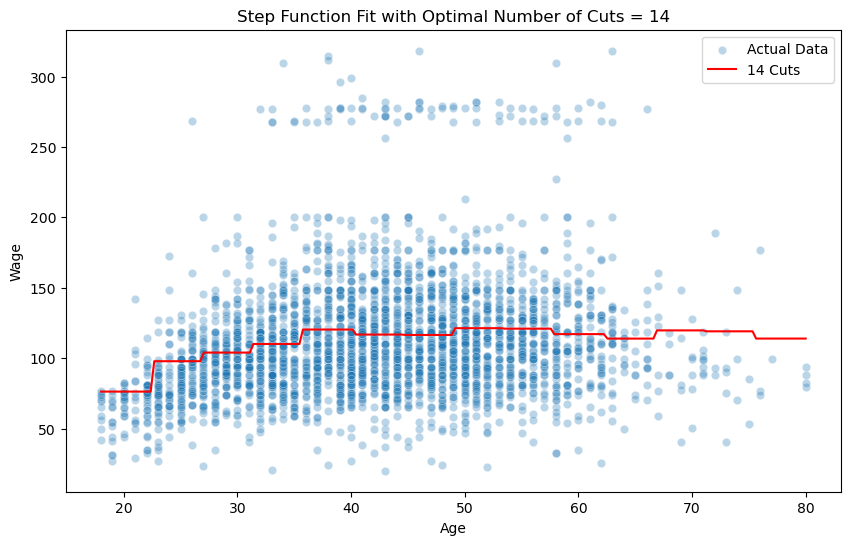

In [78]:
#Using the optimal cuts=14
cut_age = pd.qcut(age, q=best_cuts)
X_cut = pd.get_dummies(cut_age)
best_step_model = sm.OLS(y, X_cut).fit()

#Generate a range of features for prediction
age_range = np.linspace(age.min(), age.max(), 200)
cut_age_range = pd.qcut(age_range, q=best_cuts, labels=False, duplicates='drop')
X_cut_range = pd.get_dummies(cut_age_range)
predictions = best_step_model.predict(X_cut_range)

#Plot step function
plt.figure(figsize=(10, 6))
sns.scatterplot(x=age, y=y, alpha=0.3, label='Actual Data')
sns.lineplot(x=age_range, y=predictions, color='red', label=f'{best_cuts} Cuts')
plt.xlabel('Age')
plt.ylabel('Wage')
plt.title(f'Step Function Fit with Optimal Number of Cuts = {best_cuts}')
plt.legend()
plt.show()

***
***
### **Q6**

***
#### Q6(a) 

In [79]:
Boston = load_data('Boston')
y = Boston['nox']
dis = Boston['dis']

In [80]:
Boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


In [81]:
Boston['dis'].describe()

count    506.000000
mean       3.795043
std        2.105710
min        1.129600
25%        2.100175
50%        3.207450
75%        5.188425
max       12.126500
Name: dis, dtype: float64

In [82]:
Boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  lstat    506 non-null    float64
 12  medv     506 non-null    float64
dtypes: float64(10), int64(3)
memory usage: 51.5 KB


In [83]:
#10%, 20%, ..., 90% percentile 에 knot 두기
knots_9 = np.percentile(Boston['dis'], np.linspace(10, 90, 9))
#보편적인 방법으로, 25%, 50%, 75% percentile에 knot 두기
knots_3=np.percentile(Boston['dis'], [25,50,75]) 

In [84]:
#when there are 3 knots

bs_ = BSpline(internal_knots=knots_3, intercept=True).fit(dis)
bs_dis = MS([bs('dis', internal_knots=knots_3)])
Xbs = bs_dis.fit_transform(Boston)
M = sm.OLS(y, Xbs).fit()
summarize(M)

,coef,std err,t,P>|t|
intercept,0.6562,0.024,27.689,0.000
"bs(dis, internal_knots=[2.100175 3.20745 5.188425])[0]",0.1022,0.035,2.907,0.004
"bs(dis, internal_knots=[2.100175 3.20745 5.188425])[1]",-0.0296,0.023,-1.267,0.206
"bs(dis, internal_knots=[2.100175 3.20745 5.188425])[2]",-0.1596,0.028,-5.718,0.000
"bs(dis, internal_knots=[2.100175 3.20745 5.188425])[3]",-0.2281,0.033,-6.864,0.000
"bs(dis, internal_knots=[2.100175 3.20745 5.188425])[4]",-0.2627,0.049,-5.329,0.000
"bs(dis, internal_knots=[2.100175 3.20745 5.188425])[5]",-0.2400,0.054,-4.417,0.000


In [85]:
Xbs.head(10)

,intercept,"bs(dis, internal_knots=[2.100175 3.20745 5.188425])[0]","bs(dis, internal_knots=[2.100175 3.20745 5.188425])[1]","bs(dis, internal_knots=[2.100175 3.20745 5.188425])[2]","bs(dis, internal_knots=[2.100175 3.20745 5.188425])[3]","bs(dis, internal_knots=[2.100175 3.20745 5.188425])[4]","bs(dis, internal_knots=[2.100175 3.20745 5.188425])[5]"
0,1.0,0.0,0.053373,0.751972,0.190293,0.004362,0.000000
1,1.0,0.0,0.000437,0.590775,0.374213,0.034575,0.000000
2,1.0,0.0,0.000437,0.590775,0.374213,0.034575,0.000000
3,1.0,0.0,0.000000,0.359453,0.499908,0.138641,0.001997
4,1.0,0.0,0.000000,0.359453,0.499908,0.138641,0.001997
5,1.0,0.0,0.000000,0.359453,0.499908,0.138641,0.001997
6,1.0,0.0,0.000000,0.456250,0.461614,0.081981,0.000154
7,1.0,0.0,0.000000,0.379684,0.493983,0.125008,0.001325
8,1.0,0.0,0.000000,0.355926,0.500815,0.141122,0.002137
9,1.0,0.0,0.000000,0.273220,0.509732,0.208767,0.008281


In [86]:
print(BSpline(df=6).fit(dis).internal_knots_) #when degrees of freedom is 6
print(knots_3) #when there are 3 knots

[2.100175 3.20745  5.188425]
[2.100175 3.20745  5.188425]


From the fact that these two results are the same, I found that the degree of freedom adjustment is the adjustment of the number of knots through the percentile adjustment.

In [87]:
print(BSpline(df=12).fit(dis).internal_knots_)
print(knots_9)

[1.6283  1.9512  2.25965 2.6403  3.20745 3.875   4.5404  5.615   6.8166 ]
[1.6283  1.9512  2.25965 2.6403  3.20745 3.875   4.5404  5.615   6.8166 ]


Likewise, the above two results are the same

6 4.651670452174841
7 4.038403724692655
8 3.691307386881299
9 3.558645592424596
10 3.4972805032423318
11 3.408442220337952
12 3.3287533881628653
13 3.2679567729069436


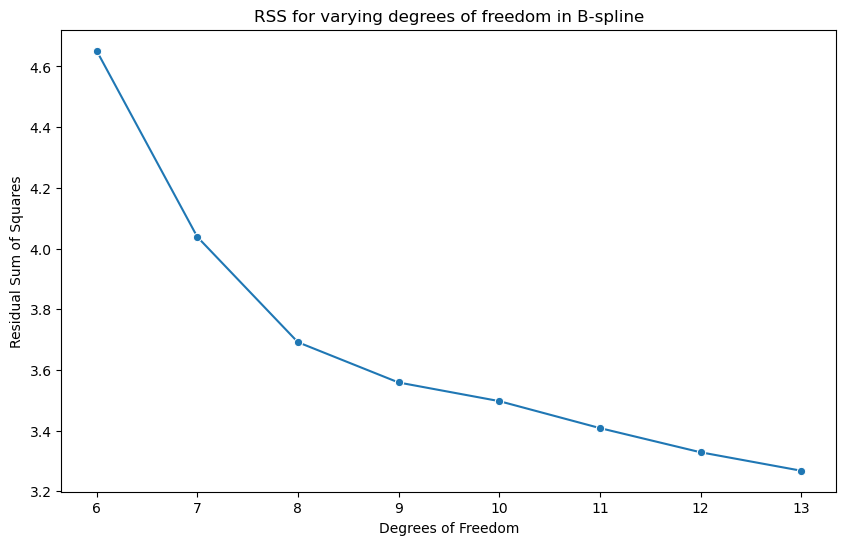

In [92]:
y = Boston['nox']
dis = Boston['dis'].values.reshape(-1, 1)

degrees_of_freedom = list(range(6,14))
rss_list=[]

for degree in degrees_of_freedom:
    #Generate new B-spline features for the 'dis' feature with varying degrees of freedom
    bspl = BSpline(df=degree).fit(dis)  #we should fit BSpline on the 'dis' column only
    knots_list = bspl.internal_knots_
    bs_dis = bspl.transform(dis)  #Transform 'dis' using the fitted BSpline

    M = sm.OLS(y, bs_dis).fit()

    predictions = M.predict(bs_dis)
    residuals = y - predictions
    rss = np.sum(residuals**2)
    rss_list.append(rss)
    print(degree, rss)  #Print RSS for each degree of freedom

plt.figure(figsize=(10, 6))
sns.lineplot(x=degrees_of_freedom, y=rss_list, marker='o')
plt.title('RSS for varying degrees of freedom in B-spline')
plt.xlabel('Degrees of Freedom')
plt.ylabel('Residual Sum of Squares')
plt.xticks(degrees_of_freedom)
plt.show()

***
#### Q6(b) 

Degrees of Freedom 6: Cross-validation MSE = 0.0052
Degrees of Freedom 7: Cross-validation MSE = 0.0052
Degrees of Freedom 8: Cross-validation MSE = 0.0055
Degrees of Freedom 9: Cross-validation MSE = 0.0053
Degrees of Freedom 10: Cross-validation MSE = 0.0056
Degrees of Freedom 11: Cross-validation MSE = 0.0060
Degrees of Freedom 12: Cross-validation MSE = 0.0054
Degrees of Freedom 13: Cross-validation MSE = 0.0071

Optimal degrees of freedom: 7
Knots are [1.9512 2.6403 3.875  5.615 ]


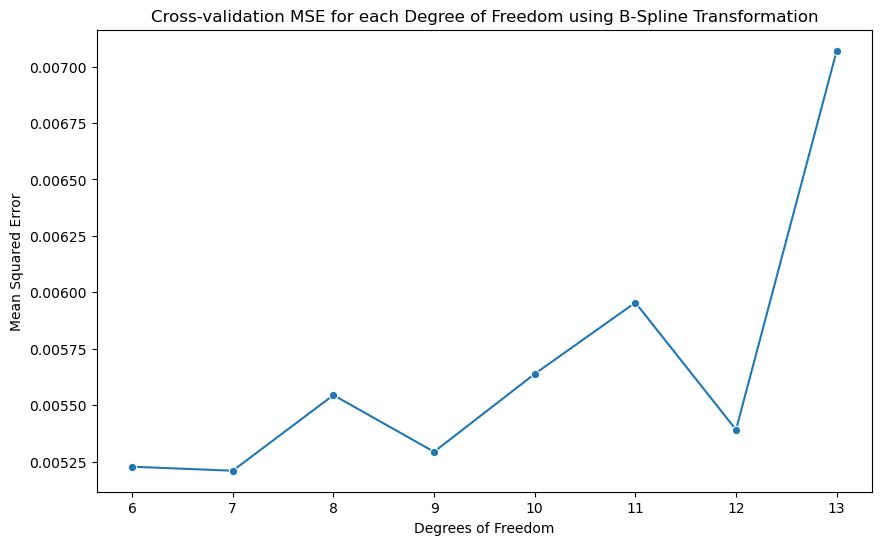

In [93]:
#Cross-validation
degrees_of_freedom = list(range(6, 14))
mse_scores = []

for degree in degrees_of_freedom:
    #Generate new B-spline features for the 'dis' feature with varying degrees of freedom
    bspl = BSpline(df=degree).fit(dis) #Fit BSpline on the 'dis' column only
    knots_list = bspl.internal_knots_
    bs_dis = bspl.transform(dis) #Transform 'dis' using the fitted BSpline
    model = LinearRegression()

    score = -np.mean(cross_val_score(model, bs_dis, y, scoring='neg_mean_squared_error', cv=5))
    mse_scores.append(score)

    #Print the cross-validation scores for degrees of freedom 6~13
    print(f"Degrees of Freedom {degree}: Cross-validation MSE = {score:.4f}")

#Finding the optimal degrees of freedom
optimal_index = np.argmin(mse_scores)
best_df = degrees_of_freedom[optimal_index]
print(f"\nOptimal degrees of freedom: {best_df}")
print(f"Knots are {BSpline(df=best_df).fit(dis).internal_knots_}")

scores_df = pd.DataFrame({'Degrees of Freedom': degrees_of_freedom, 'MSE': mse_scores})
plt.figure(figsize=(10, 6))
sns.lineplot(x='Degrees of Freedom', y='MSE', data=scores_df, marker='o')
plt.title('Cross-validation MSE for each Degree of Freedom using B-Spline Transformation')
plt.xlabel('Degrees of Freedom')
plt.ylabel('Mean Squared Error')
plt.xticks(degrees_of_freedom)
plt.show()

Through the graph above, I found that if the degree of freedom is too high, it may be seen that the MSE may increase due to overfitting.  
And the optimal degrees of freedom is 7, which means that there are 4 knots : `[1.9512, 2.6403, 3.875, 5.615]`

***
***
### **Q7**

***
#### Q7(a) 

In [94]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS
from sklearn.tree import DecisionTreeClassifier as DTC, DecisionTreeRegressor as DTR, plot_tree, export_text
from sklearn.metrics import accuracy_score, log_loss
from sklearn.ensemble import RandomForestRegressor as RF, GradientBoostingRegressor as GBR

In [95]:
Carseats=load_data('CarSeats')
Carseats.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


In [96]:
Carseats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Sales        400 non-null    float64
 1   CompPrice    400 non-null    int64  
 2   Income       400 non-null    int64  
 3   Advertising  400 non-null    int64  
 4   Population   400 non-null    int64  
 5   Price        400 non-null    int64  
 6   ShelveLoc    400 non-null    object 
 7   Age          400 non-null    int64  
 8   Education    400 non-null    int64  
 9   Urban        400 non-null    object 
 10  US           400 non-null    object 
dtypes: float64(1), int64(7), object(3)
memory usage: 34.5+ KB


Test MSE: 5.0176


[Text(0.5, 0.8333333333333334, 'ShelveLoc_Good <= 0.5\nsquared_error = 8.438\nsamples = 280\nvalue = 7.378'),
 Text(0.25, 0.5, 'ShelveLoc_Medium <= 0.5\nsquared_error = 6.26\nsamples = 226\nvalue = 6.705'),
 Text(0.125, 0.16666666666666666, 'squared_error = 5.251\nsamples = 71\nvalue = 5.159'),
 Text(0.375, 0.16666666666666666, 'squared_error = 5.127\nsamples = 155\nvalue = 7.413'),
 Text(0.75, 0.5, 'Price <= 107.5\nsquared_error = 7.698\nsamples = 54\nvalue = 10.198'),
 Text(0.625, 0.16666666666666666, 'squared_error = 3.888\nsamples = 20\nvalue = 12.345'),
 Text(0.875, 0.16666666666666666, 'squared_error = 5.636\nsamples = 34\nvalue = 8.936')]

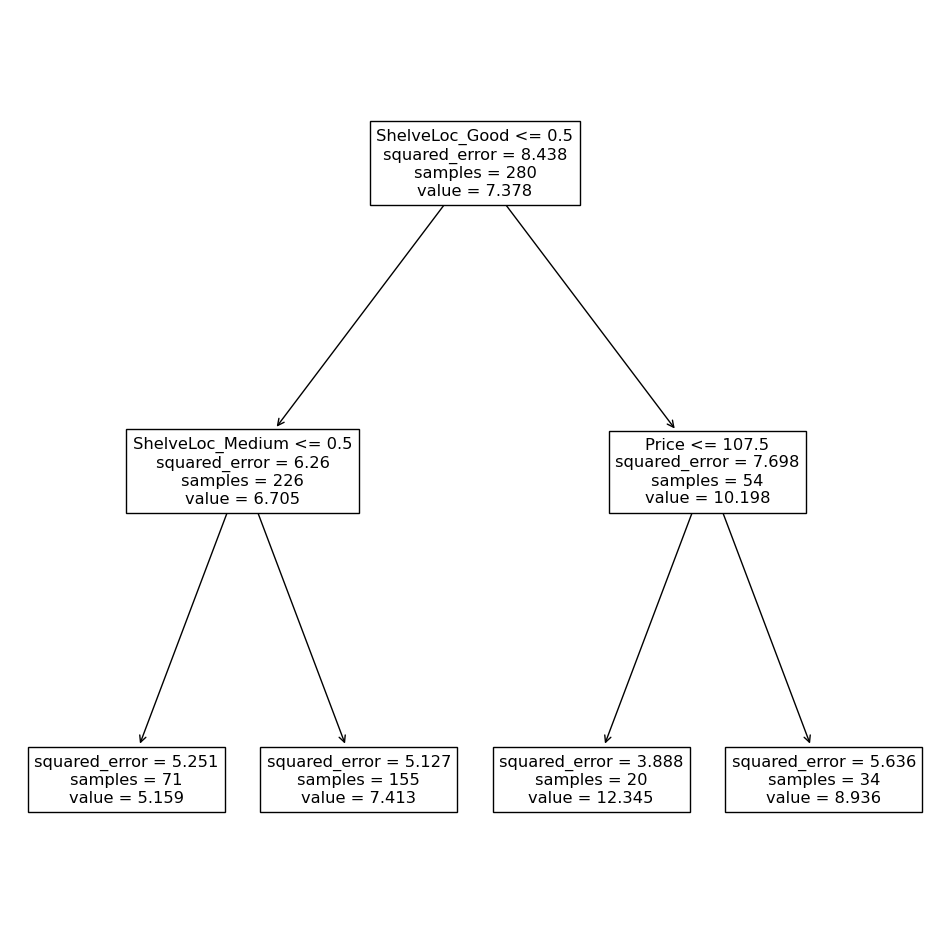

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

#I found that there are object types in data set, so we need to add dummy variables.
Carseats = pd.get_dummies(Carseats)

#Split the data set into train set and test set.
train_set, test_set = train_test_split(Carseats, test_size=0.3, random_state=0)

X_train=train_set.drop(columns=['Sales'])
y_train=train_set['Sales']

X_test=test_set.drop(columns=['Sales'])
y_test=test_set['Sales']

#I used DicisionTreeRegressor. 
#And I briefly set max_depth to two, I will compute optimal level of tree complexity in next question.
reg=DTR(max_depth=2, random_state=0)
reg.fit(X_train, y_train)

#print test MSE
y_pred = reg.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {test_mse:.4f}")

ax=subplots(figsize=(12,12))[1]
plot_tree(reg, feature_names=list(X_train.columns), ax=ax)

***
#### Q7(b) 

Max_depth 1: Test MSE: 4.6303
Max_depth 2: Test MSE: 5.0176
Max_depth 3: Test MSE: 3.7039
Max_depth 4: Test MSE: 4.3099
Max_depth 5: Test MSE: 3.9573
Max_depth 6: Test MSE: 3.8438
Max_depth 7: Test MSE: 3.9552
Max_depth 8: Test MSE: 3.9192
Max_depth 9: Test MSE: 3.8558
Max_depth 10: Test MSE: 3.8558

Optimal max_depth: 3


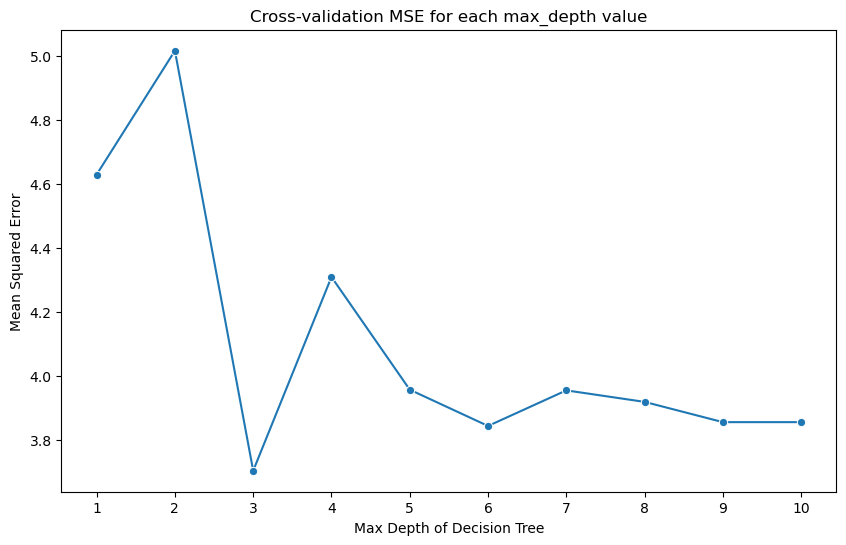

In [99]:
max_depths = list(range(1, 11))
mse_scores = []

for max_depth in max_depths:
    reg=DTR(max_depth=max_depth,random_state=0)

    ccp_path = reg.cost_complexity_pruning_path(X_train, y_train)
    kfold = skm.KFold(5, shuffle=True, random_state=0)
    grid = skm.GridSearchCV(reg, {'ccp_alpha': ccp_path.ccp_alphas}, refit=True, cv=kfold, scoring='neg_mean_squared_error')
    G = grid.fit(X_train, y_train)

    y_pred = G.predict(X_test)
    test_mse = mean_squared_error(y_test, y_pred)
    mse_scores.append(test_mse)
    print(f"Max_depth {max_depth}: Test MSE: {test_mse:.4f}") #Print the cross-validation Test MSE for max_depth 1~10

#Finding the optimal max_depth
optimal_index = np.argmin(mse_scores)
best_depth = max_depths[optimal_index]
print(f"\nOptimal max_depth: {best_depth}")

scores_df = pd.DataFrame({'Max_depth': max_depths, 'MSE': mse_scores})
plt.figure(figsize=(10, 6))
sns.lineplot(x='Max_depth', y='MSE', data=scores_df, marker='o')
plt.title('Cross-validation MSE for each max_depth value')
plt.xlabel('Max Depth of Decision Tree')
plt.ylabel('Mean Squared Error')
plt.xticks(max_depths)
plt.show()

Pruning the decision tree to a maximum depth of 3 optimizes its performance.  
I found that when the the `max_depth` of decision tree is 3, we can have the lowest MSE.  
For `max_depth>3`, increasing tree complexity results in higher MSE, indicating overfitting.  
Therefore, tree pruning improves the test MSE for this dataset.

***
#### Q7(c) 

In [100]:
#BaggingRegressor
#Bagging is a special case of a Randomforest with m=p.
#And also, Bagging is the method that use all p predictors, so I made max_features=X_train.shape[1].

bgr = RF(max_features=X_train.shape[1],random_state=0)
bgr.fit(X_train, y_train)
y_pred = bgr.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {test_mse:.4f}")

Test MSE: 2.1006


             Feature  Importance
4              Price    0.276948
8     ShelveLoc_Good    0.181296
5                Age    0.104809
0          CompPrice    0.097882
7      ShelveLoc_Bad    0.086165
2        Advertising    0.072039
1             Income    0.053028
3         Population    0.042258
9   ShelveLoc_Medium    0.041852
6          Education    0.030831
13            US_Yes    0.003634
12             US_No    0.003626
11         Urban_Yes    0.003259
10          Urban_No    0.002373


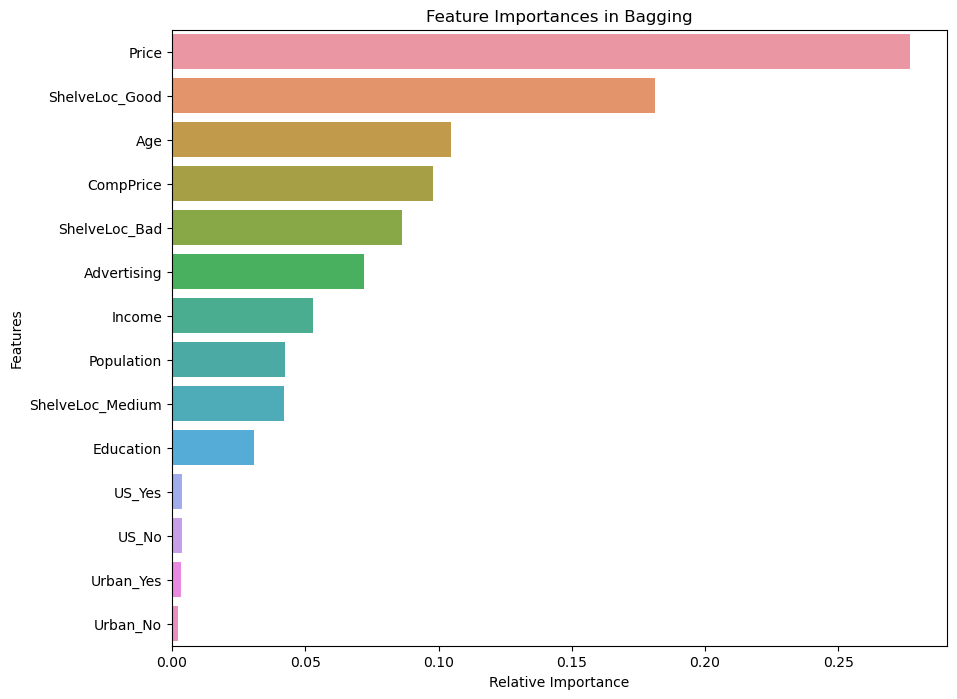

In [101]:
#I created a dataframe of feature importances by using feature_importances_
feature_imp = pd.DataFrame({'Feature': X_train.columns, 'Importance': bgr.feature_importances_})
#Sortting by importance in descending order
feature_imp = feature_imp.sort_values('Importance', ascending=False)
print(feature_imp)

#I plotted a bar chart for visualization
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp)
plt.title('Feature Importances in Bagging')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.show()

Through the graph above, I found that `Price` is the most important varibles among all features.

***
#### Q7(d) 

In [102]:
#Randomforest
#In randomforest, we use the m=p^0.5. Therefore, we should set max_features=int(X_train.shape[1]**0.5).
#But I realized that the RF automatically set max_features properly if I set max_features='sqrt'.

rf = RF(max_features='sqrt', random_state=0)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {test_mse:.4f}")

Test MSE: 2.4892


             Feature  Importance
4              Price    0.202796
8     ShelveLoc_Good    0.130043
5                Age    0.114988
7      ShelveLoc_Bad    0.085509
0          CompPrice    0.085291
1             Income    0.084190
2        Advertising    0.080447
3         Population    0.075802
6          Education    0.051163
9   ShelveLoc_Medium    0.043449
12             US_No    0.013951
13            US_Yes    0.011952
10          Urban_No    0.010576
11         Urban_Yes    0.009842


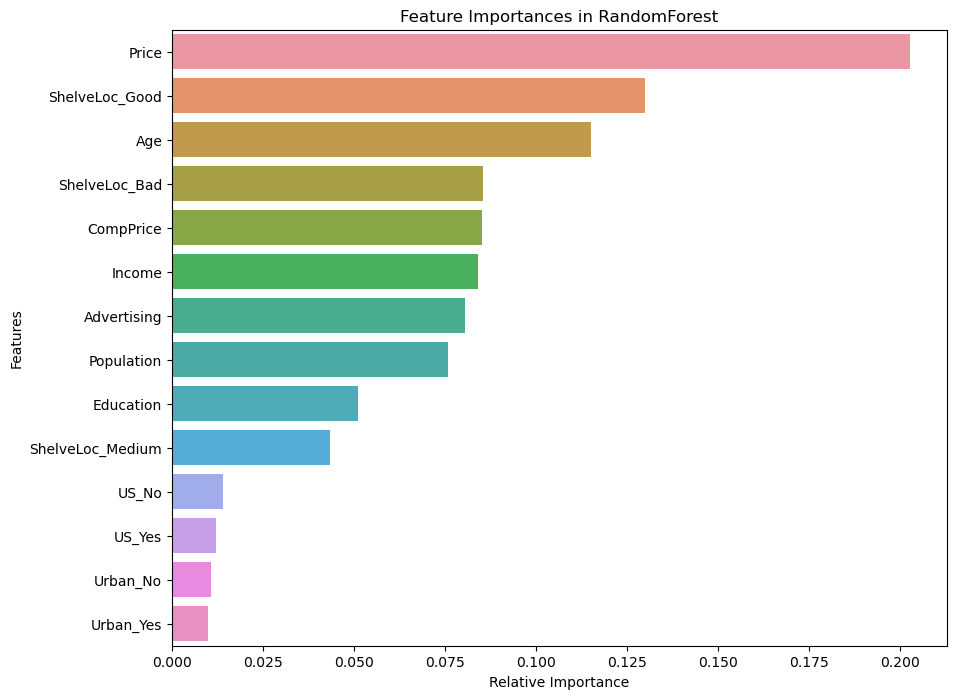

In [103]:
#I created a dataframe of feature importances by using feature_importances_
feature_imp = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf.feature_importances_})
#Sortting by importance in descending order
feature_imp = feature_imp.sort_values('Importance', ascending=False)
print(feature_imp)

#I plotted a bar chart for visualization
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp)
plt.title('Feature Importances in RandomForest')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.show()

Just like problem (c), Price is the most important feature.  
If we see the graph above, 'Price' is the most important varibles among all features.

Finally, let's describe the effect of m, the number of variables considered at each split, on the error rate obtained.

In comparison to case (c) where `m=p` led to `max_features` being set to 14, this problem's setting of `m=sqrt(p)` results in a `max_features` value of 3.  
This is a relatively small number of features to consider at each split and could cause the model to miss capturing significant patterns in the data.

As a result, the test MSE in case (d) turned out to be higher than that in case (c). And also, this had an impact on the calculated feature importance.  
For instance, the importance of 'Price' is seen to diminish in (d), which implies that a smaller `max_features` value can lead the model to overlook essential patterns.


***
***
### **Q8**

***
#### Q8(a) 

In [64]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
import sklearn.model_selection as skm
from ISLP import load_data, confusion_table
from ISLP.models import ModelSpec as MS
from sklearn.tree import DecisionTreeClassifier as DTC, DecisionTreeRegressor as DTR, plot_tree, export_text
from sklearn.metrics import accuracy_score, log_loss
from sklearn.ensemble import RandomForestRegressor as RF, GradientBoostingRegressor as GBR
from sklearn.metrics import mean_squared_error

In [54]:
Hitter=load_data("Hitters")
Hitter.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [55]:
Hitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   AtBat      322 non-null    int64   
 1   Hits       322 non-null    int64   
 2   HmRun      322 non-null    int64   
 3   Runs       322 non-null    int64   
 4   RBI        322 non-null    int64   
 5   Walks      322 non-null    int64   
 6   Years      322 non-null    int64   
 7   CAtBat     322 non-null    int64   
 8   CHits      322 non-null    int64   
 9   CHmRun     322 non-null    int64   
 10  CRuns      322 non-null    int64   
 11  CRBI       322 non-null    int64   
 12  CWalks     322 non-null    int64   
 13  League     322 non-null    category
 14  Division   322 non-null    category
 15  PutOuts    322 non-null    int64   
 16  Assists    322 non-null    int64   
 17  Errors     322 non-null    int64   
 18  Salary     263 non-null    float64 
 19  NewLeague  322 non-null    ca

In [56]:
Hitter.isna().sum()

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

In [57]:
Hitter=load_data("Hitters")

#I removed 59 NA observations.
Hitter = Hitter.dropna(subset=['Salary'])

#Log-transform the 'Salary'
Hitter['Salary'] = np.log(Hitter['Salary'])

#There are several category type predictors. So I needed to deal with them.
Hitter = pd.get_dummies(Hitter)

#Training set with the first 200 observations, and Test set with remaining observations
train_set, test_set = Hitter.iloc[:200], Hitter.iloc[200:]

X_train=train_set.drop(columns=['Salary'])
y_train=train_set['Salary']

X_test=test_set.drop(columns=['Salary'])
y_test=test_set['Salary']


Training set : when shrinkage parameter = 0.5, minimum MSE = 0.0000
Test set : when shrinkage parameter = 0.0037000211913891527, minimum MSE = 0.2048


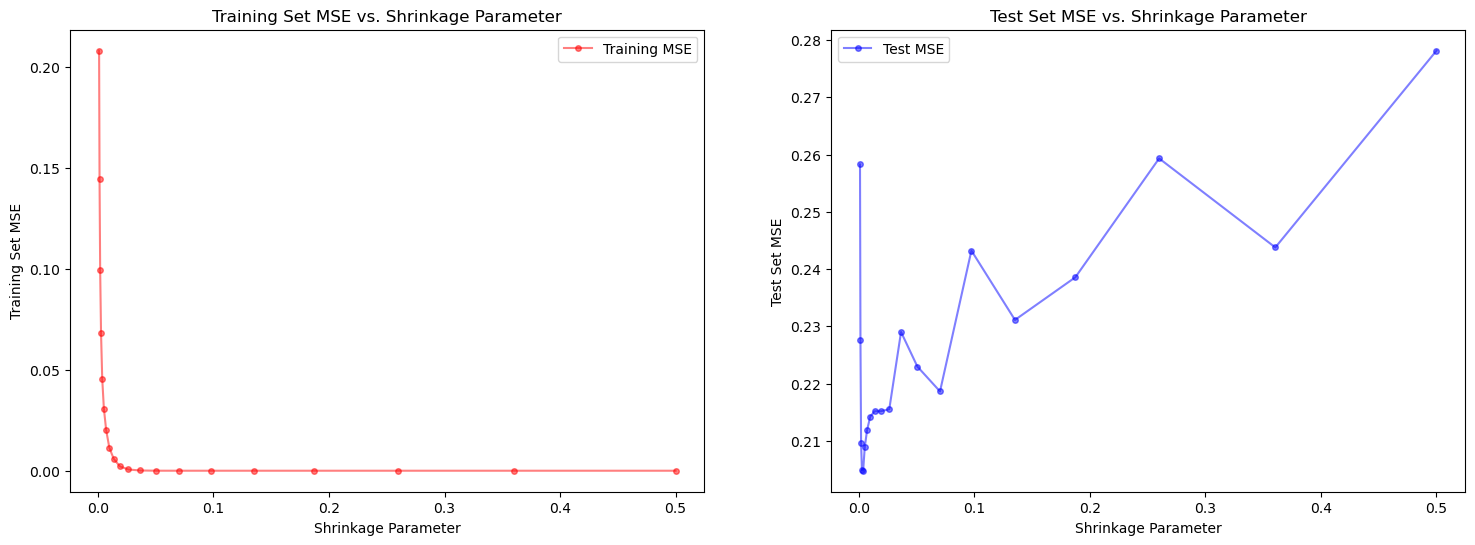

In [60]:
#Shrinkage parameter is learning rate in GradientBoostingRegressor()

# Generate 20 logarithmically spaced values for learning rates between 0.001 and 0.5
learning_rates = np.logspace(np.log10(0.001), np.log10(0.5), num=20)
train_mse, test_mse = [], []

for lr in learning_rates: #lr is the learning rate, the shrinkage parameter lamda.
    #n_estimators indicates the number of trees, and I just breifly set max_depth to 3.
    gbr = GBR(n_estimators=1000, learning_rate=lr, max_depth=3, random_state=0)
    gbr.fit(X_train, y_train)
    
    #Training set MSE
    train_pred = gbr.predict(X_train)
    train_mse.append(mean_squared_error(y_train, train_pred))
    
    #Test set MSE
    test_pred = gbr.predict(X_test)
    test_mse.append(mean_squared_error(y_test, test_pred))

#Find the index of the minimum MSE score for the training and test sets
optimal_train_index, optimal_test_index = np.argmin(train_mse), np.argmin(test_mse)
#Find the optimal learning rates based on the minimum MSE scores
optimal_train_lr, optimal_test_lr = learning_rates[optimal_train_index], learning_rates[optimal_test_index]
#Output the minimum MSE and corresponding learning rates
print(f"Training set : when shrinkage parameter = {optimal_train_lr}, minimum MSE = {train_mse[optimal_train_index]:.4f}")
print(f"Test set : when shrinkage parameter = {optimal_test_lr}, minimum MSE = {test_mse[optimal_test_index]:.4f}")

#Plot MSE
fig, axes = plt.subplots(ncols=2, figsize=(18, 6))
axes[0].plot(learning_rates, train_mse, label='Training MSE', marker='o', color='red', markersize=4, alpha=0.5)
axes[0].set_xlabel('Shrinkage Parameter')
axes[0].set_ylabel('Training Set MSE')
axes[0].set_title('Training Set MSE vs. Shrinkage Parameter')
axes[0].legend()
axes[1].plot(learning_rates, test_mse, label='Test MSE', marker='o', color='blue', markersize=4, alpha=0.5)
axes[1].set_xlabel('Shrinkage Parameter')
axes[1].set_ylabel('Test Set MSE')
axes[1].set_title('Test Set MSE vs. Shrinkage Parameter')
axes[1].legend()
plt.show()

Seeing the graph above, I could found that when the Shrinkage Parameter, the learning rate is too high, there should be Overfitting issues.

***
#### Q8(b)

In [61]:
from sklearn.linear_model import LinearRegression, LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

#Linear regression
#I made a pipeline to perform scaling.
linear_pipeline = make_pipeline(StandardScaler(), LinearRegression())
linear_pipeline.fit(X_train, y_train)
linear_test_pred = linear_pipeline.predict(X_test)
linear_test_mse = mean_squared_error(y_test, linear_test_pred)

#Lasso Regression
#I made a pipeline to perform scaling and finding an appropriate alphas through 10-fold cross-validation in LassoCV
lasso_cv_pipeline = make_pipeline(StandardScaler(), LassoCV(alphas=None, cv=5, max_iter=1000))
lasso_cv_pipeline.fit(X_train, y_train)
lasso_cv_test_pred = lasso_cv_pipeline.predict(X_test)
lasso_cv_test_mse = mean_squared_error(y_test, lasso_cv_test_pred)

print(f"Linear Regression Test MSE: {linear_test_mse:.4f}")
print(f"Lasso Regression Test MSE: {lasso_cv_test_mse:.4f}")

Linear Regression Test MSE: 0.4918
Lasso Regression Test MSE: 0.4561


In problem (a), the minimum test MSE of boosting was about `0.2048`.  
And this is much smaller than the value above in problem (b).  
Based on these results, I conclude that boosting performs better than both Linear Regression and Lasso Regression in this scenario.

***
#### Q8(c)

This is similar to the Q7(c).

        Feature  Importance
7        CAtBat    0.553599
8         CHits    0.095809
10        CRuns    0.050936
0         AtBat    0.047326
5         Walks    0.046930
11         CRBI    0.040144
12       CWalks    0.034140
9        CHmRun    0.031102
6         Years    0.025038
1          Hits    0.023210
4           RBI    0.018289
13      PutOuts    0.012396
3          Runs    0.009679
15       Errors    0.004991
14      Assists    0.002574
2         HmRun    0.001590
20  NewLeague_A    0.000725
21  NewLeague_N    0.000553
16     League_A    0.000351
19   Division_W    0.000229
17     League_N    0.000211
18   Division_E    0.000180


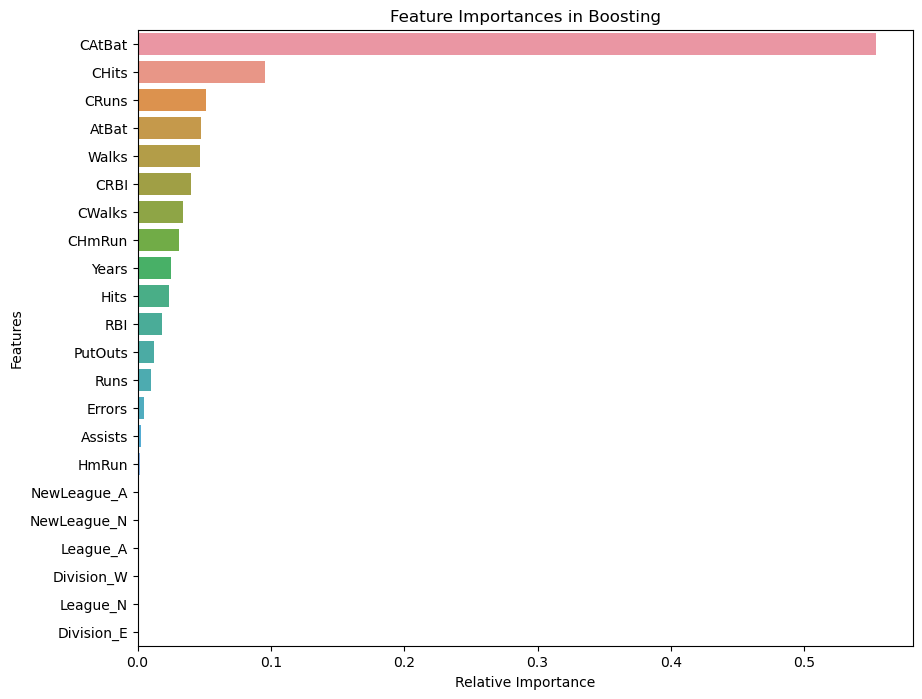

In [67]:
best_gbr = GBR(n_estimators=1000, learning_rate=optimal_test_lr, max_depth=3, random_state=0)
best_gbr.fit(X_train, y_train)

feature_imp = pd.DataFrame({'Feature': X_train.columns, 'Importance': best_gbr.feature_importances_})
feature_imp = feature_imp.sort_values('Importance', ascending=False)
print(feature_imp)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp)
plt.title('Feature Importances in Boosting')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.show()

Through the graph above, I found that `CAtBat` is the most important variables among all features.